In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
import genjax
import rerun as rr
from tqdm import tqdm

rr.init("demo.py")
rr.connect("127.0.0.1:8812")


In [2]:
# Load date
path = os.path.join(b3d.get_root_path(),
"assets/shared_data_bucket/input_data/shout_on_desk.r3d.video_input.npz")
video_input = b3d.VideoInput.load(path)

# Get intrinsics
image_width, image_height, fx,fy, cx,cy,near,far = np.array(video_input.camera_intrinsics_depth)
image_width, image_height = int(image_width), int(image_height)
fx,fy, cx,cy,near,far = float(fx),float(fy), float(cx),float(cy),float(near),float(far)

# Get RGBS and Depth
rgbs = video_input.rgb[::3] / 255.0
xyzs = video_input.xyz[::3]

# Resize rgbs to be same size as depth.
rgbs_resized = jnp.clip(jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    rgbs, (video_input.xyz.shape[1], video_input.xyz.shape[2], 3), "linear"
), 0.0, 1.0)


num_layers = 2048
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far, num_layers)
model = b3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.02))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(5.0), jnp.float32(0.001))
# TODO: explain
color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))


# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.
translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.01, 0.01, 11),
        jnp.linspace(-0.01, 0.01, 11),
        jnp.linspace(-0.01, 0.01, 11),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 11*11*11),
    Pose.identity(),
    0.00001, 1000.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])


In [4]:


# Make empty library
object_library = b3d.MeshLibrary.make_empty_library()

# Take point cloud at frame 0
point_cloud = jax.image.resize(xyzs[0], (xyzs[0].shape[0]//3, xyzs[0].shape[1]//3, 3), "linear").reshape(-1,3)
colors = jax.image.resize(rgbs_resized[0], (xyzs[0].shape[0]//3, xyzs[0].shape[1]//3, 3), "linear").reshape(-1,3)

# `make_mesh_from_point_cloud_and_resolution` takes a 3D positions, colors, and sizes of the boxes that we want
# to place at each position and create a mesh
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, colors,
    point_cloud[:,2] / fx * 3.0 # This is scaling the size of the box to correspond to the effective size of the pixel in 3D. It really should be multiplied by 2.
    # and the 6 makes it larger
)
object_library.add_object(vertices, faces, vertex_colors)


# Initial trace for timestep 0
START_T = 0
trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", Pose.identity()),
            ("object_0", 0),
            ("observed_rgb_depth", (rgbs_resized[START_T], xyzs[START_T,...,2])),
        ])
    ),
    (jnp.arange(1),color_error,depth_error,inlier_score,outlier_prob,color_multiplier,depth_multiplier, object_library)
)
# Visualize trace
b3d.rerun_visualize_trace_t(trace, 0)


In [5]:
ACQUISITION_T = 120
for T_observed_image in tqdm(range(ACQUISITION_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs_resized[T_observed_image],xyzs[T_observed_image,...,2])
    )
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    b3d.rerun_visualize_trace_t(trace, T_observed_image)

100%|██████████| 120/120 [00:38<00:00,  3.09it/s]


In [6]:
## track the single shout triangle

In [7]:
xyzs.shape

(248, 256, 192, 3)

In [8]:
h_min, h_max = 125, 155
w_min, w_max = 85, 115
point_cloud = xyzs[T_observed_image,h_min:h_max,w_min:w_max,:].reshape(-1,3)
point_cloud_colors = rgbs_resized[T_observed_image,h_min:h_max,w_min:w_max,:].reshape(-1,3)

In [9]:
# Create new mesh.
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
)
object_pose = Pose.from_translation(vertices.mean(0))
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)

single_object_trace = trace

trace = single_object_trace

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", trace["camera_pose"]),
            ("object_pose_0", trace["object_pose_0"]),
            ("object_pose_1", trace["camera_pose"] @ object_pose),
            ("object_0", 0),
            ("object_1", 1),
            ("observed_rgb_depth", (rgbs_resized[ACQUISITION_T], xyzs[ACQUISITION_T,...,2])),
        ])
    ),
    (jnp.arange(2),color_error,depth_error,inlier_score,outlier_prob,color_multiplier,depth_multiplier, object_library)
)
# Visualize trace
b3d.rerun_visualize_trace_t(trace, ACQUISITION_T)

FINAL_T = len(xyzs)
for T_observed_image in tqdm(range(ACQUISITION_T, FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs_resized[T_observed_image],xyzs[T_observed_image,...,2])
    )
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_1"]), key, all_deltas)
    b3d.rerun_visualize_trace_t(trace, T_observed_image)

100%|██████████| 128/128 [01:24<00:00,  1.51it/s]


In [10]:
# generate posterior uncertainty plot


In [11]:
# extract surface normal of the mesh
# grid along the surface of the mesh

# 122, 110

In [195]:
x_center = 122
y_center = 110
del_pix = 10#5

local_points = xyzs[ACQUISITION_T,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
local_rgbs = rgbs_resized[ACQUISITION_T,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
patch_center = xyzs[ACQUISITION_T,x_center,y_center,:]


In [196]:
svd = jnp.linalg.svd(local_points.T - jnp.mean(local_points.T, axis=1, keepdims=True))


In [197]:
# normal of local patch
plane_normal = svd[0][:,-1]
translation = jnp.mean(local_points, axis=0)

In [198]:
# need to make sure this points up! in +z
# plane_x = jnp.cross(plane_normal, np.array([1.0, 0.0, 0.0]))
# plane_y = jnp.cross(plane_normal, plane_x)
# R = jnp.vstack([plane_x, plane_y, plane_normal]).T
# plane_pose = Pose(point_on_plane, Rot.from_matrix(R).as_quat())


# add make sure the default pose of the chunk also points up in +z (can't do this without checking convexity conditions)
# locally grid spins within the tangent plane, and the two flip augmentations!

In [199]:
rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)

rr.log(
    "world/xyz",
    rr.Arrows3D(
        vectors=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
        colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
    ),
)

In [200]:
plane_x = jnp.cross(plane_normal, np.array([1.0, 0.0, 0.0]))
plane_y = jnp.cross(plane_normal, plane_x)
R = jnp.vstack([plane_x, plane_y, plane_normal]).T
plane_pose = Pose(patch_center, Rot.from_matrix(R).as_quat())
canonical_patch = plane_pose.inv().apply(local_points)

rr.log("adjust_patch", rr.Points3D(canonical_patch))

In [201]:
# 95, 175
x_center_new = 175
y_center_new = 95

local_points_new = xyzs[ACQUISITION_T,x_center_new-del_pix:x_center_new+del_pix,y_center_new-del_pix:y_center_new+del_pix,:].reshape(-1,3)
patch_center_new = xyzs[ACQUISITION_T,x_center_new,y_center_new,:]

svd = jnp.linalg.svd(local_points_new.T - jnp.mean(local_points_new.T, axis=1, keepdims=True))
plane_normal = svd[0][:,-1]
plane_x = jnp.cross(plane_normal, np.array([1.0, 0.0, 0.0]))
plane_y = jnp.cross(plane_normal, plane_x)
R = jnp.vstack([plane_x, plane_y, plane_normal]).T
plane_pose = Pose(patch_center_new, Rot.from_matrix(R).as_quat())

rr.log("shifted_patch", rr.Points3D(plane_pose.apply(canonical_patch)))

In [202]:
# patch proposals 
# 
from jax.scipy.spatial.transform import Rotation as Rot

def get_plane_pose(xyz, center_point_inds, del_pix=3):
    x_center, y_center = center_point_inds
    local_points = xyz[x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
    patch_center = xyz[x_center,y_center,:]
    svd = jnp.linalg.svd(local_points.T - jnp.mean(local_points.T, axis=1, keepdims=True))
    plane_normal = svd[0][:,-1]
    plane_x = jnp.cross(plane_normal, np.array([1.0, 0.0, 0.0]))
    plane_y = jnp.cross(plane_normal, plane_x)
    R = jnp.vstack([plane_x, plane_y, plane_normal]).T
    plane_pose = Pose(patch_center, Rot.from_matrix(R).as_quat())
    return plane_pose

def get_surface_rot_poses_from_plane_pose(num_rots = 400):
    # two cycles of rotation to cover normal plane orientation parity
    rots = Rot.from_rotvec(jnp.outer(jnp.repeat(jnp.linspace(0, 2 * jnp.pi, num_rots//2)[:, jnp.newaxis], 2, axis=-1), jnp.array([0,0,1])))
    flips = Rot.from_rotvec(jnp.outer(jnp.repeat(jnp.array([0,jnp.pi])[jnp.newaxis, :], num_rots//2, axis=0), jnp.array([0,1,0])))
    threeD_rots = rots * flips
    #positions = jnp.zeros((num_rots, 3))
    #rot_deltas = Pose.from_vec(jnp.hstack((positions,threeD_rots.as_quat()))) # needed to fix position dimension bug
    rot_deltas = threeD_rots
    return Pose(jnp.zeros((num_rots, 3)), rot_deltas.as_quat()) #@ plane_pose

In [203]:
get_surface_rot_poses_from_plane_pose()

Pose(position=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), quaternion=Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, -4.3711388e-08],
       [ 0.0000000e+00,  0.0000000e+00,  1.5786244e-02,  9.9987549e-01],
       ...,
       [-1.5786624e-02, -9.9987549e-01, -6.9005518e-10,  4.3705946e-08],
       [ 0.0000000e+00,  0.0000000e+00, -8.7422777e-08, -1.0000000e+00],
       [ 8.7422777e-08, -1.0000000e+00,  3.8213709e-15,  4.3711388e-08]],      dtype=float32))

In [204]:
xyz_At = xyzs[ACQUISITION_T]

test_pose = get_surface_rot_poses_from_plane_pose()[50]

In [205]:
rr.log("rot_canon_patch", rr.Points3D(test_pose.apply(canonical_patch)))

In [206]:
rr.log("rot_grid_patch", rr.Points3D(get_plane_pose(xyz_At, jnp.array([100, 100])).apply(test_pose.apply(canonical_patch))))

In [207]:
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    canonical_patch, local_rgbs, point_cloud[:,2] / fx * 2.0
)

In [208]:
object_pose = Pose.from_translation(vertices.mean(0))
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)

single_object_trace = trace

trace = single_object_trace

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", trace["camera_pose"]),
            ("object_pose_0", trace["object_pose_0"]),
            ("object_pose_1", trace["camera_pose"] @ object_pose),
            ("object_0", 0),
            ("object_1", 2),
            ("observed_rgb_depth", (rgbs_resized[ACQUISITION_T], xyzs[ACQUISITION_T,...,2])),
        ])
    ),
    (jnp.arange(2),color_error,depth_error,inlier_score,outlier_prob,color_multiplier,depth_multiplier, object_library)
)
# Visualize trace
b3d.rerun_visualize_trace_t(trace, ACQUISITION_T)

In [209]:
trace = b3d.update_choices_jit(trace, key,
    genjax.Pytree.const(["observed_rgb_depth"]),
    (rgbs_resized[ACQUISITION_T],xyzs[ACQUISITION_T,...,2])
)

In [210]:
# Enumerative proposal function
def enumerate_and_return_scores(trace, addressses, key, all_deltas, plane_pose):
    addr = addressses.const[0]
    current_pose = trace[addr]
    for i in range(len(all_deltas.quat)):
        test_poses = Pose.from_quat(all_deltas[i].quat) @ plane_pose @ current_pose
        potential_scores = b3d.update_choices_get_score(
            trace, jax.random.PRNGKey(0), addressses, test_poses
        )
        #current_pose = test_poses[potential_scores.argmax()]
        print(potential_scores)

In [211]:
# Enumerative proposal function
def enumerate_and_return_scores_v(trace, addressses, key, all_deltas, plane_pose):
    addr = addressses.const[0]
    current_pose = trace[addr]
    test_poses = all_deltas @ plane_pose @ current_pose
    potential_scores = b3d.update_choices_get_score(
        trace, jax.random.PRNGKey(0), addressses, test_poses
    )
    #current_pose = test_poses[potential_scores.argmax()]
    return potential_scores

enumerate_and_return_scores_vec = jax.vmap(enumerate_and_return_scores_v, (None, None, None, 0, None))

In [212]:
deltas = get_surface_rot_poses_from_plane_pose()
out = enumerate_and_return_scores_vec(trace, genjax.Pytree.const([f"object_pose_1"]), jax.random.PRNGKey(0), deltas, get_plane_pose(xyz_At, jnp.array([100, 100])))

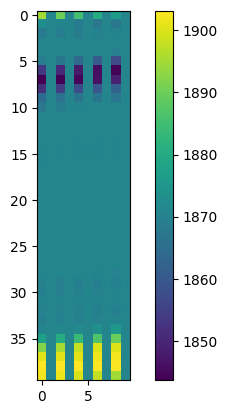

In [213]:
plt.imshow(out.reshape(40,10))
plt.colorbar()

In [214]:
MAP_pose = deltas[jnp.argmax(out)] @ plane_pose

In [215]:
rr.log("xyz", rr.Points3D(xyzs[ACQUISITION_T].reshape(-1,3), colors = rgbs_resized[ACQUISITION_T].reshape(-1,3)))

In [216]:
rr.log("MAP_patch", rr.Points3D(MAP_pose.apply(canonical_patch), colors=(local_rgbs.reshape(-1,3) * 255).astype(int)))

In [217]:
rr.log("orig_patch", rr.Points3D(local_points.reshape(-1,3)))

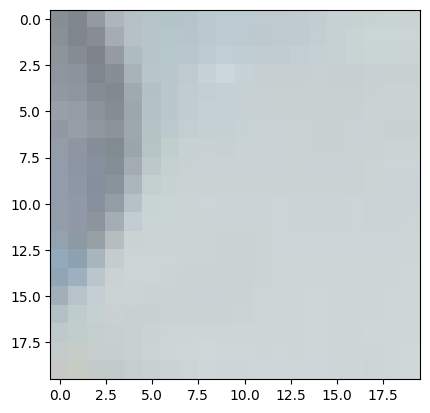

In [219]:
plt.imshow(local_rgbs.reshape(del_pix*2,del_pix*2,3))

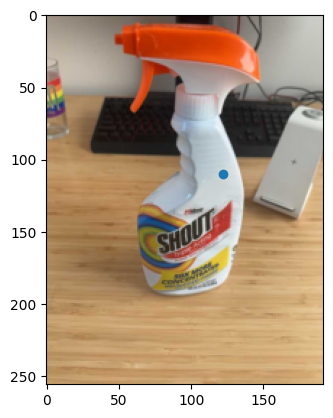

In [220]:
plt.imshow(rgbs_resized[ACQUISITION_T])
plt.scatter([x_center], [y_center])

In [221]:
xyz_At.shape

(256, 192, 3)

In [222]:
heatmap_del = 8
heatmap = np.zeros((xyz_At.shape[0]//heatmap_del, xyz_At.shape[1]//heatmap_del))
for i in jnp.arange(0,xyz_At.shape[0],heatmap_del):
    for j in jnp.arange(0,xyz_At.shape[1],heatmap_del):
        temp_out = enumerate_and_return_scores_vec(trace, genjax.Pytree.const([f"object_pose_1"]), jax.random.PRNGKey(0), deltas, get_plane_pose(xyz_At, jnp.array([i, j])))    
        heatmap[i//heatmap_del,j//heatmap_del] = temp_out.sum()
    print(i)

0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248


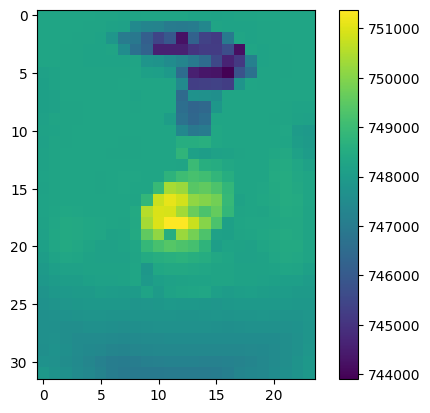

In [223]:
plt.imshow(heatmap)
plt.colorbar()

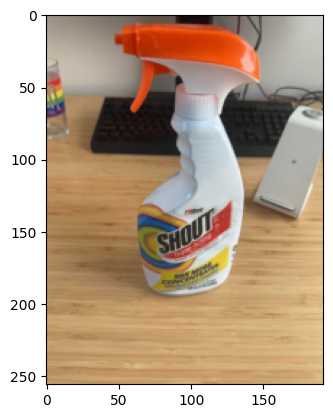

In [224]:
plt.imshow(rgbs_resized[ACQUISITION_T])

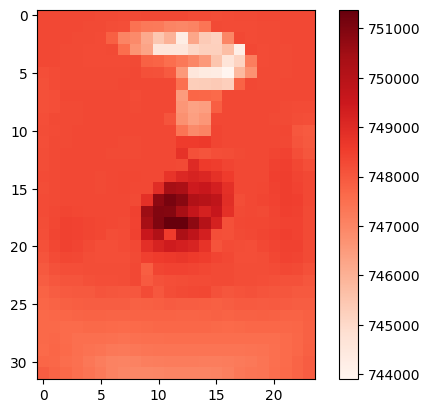

In [225]:
plt.figure()
plt.imshow(heatmap, cmap='Reds')
plt.colorbar()

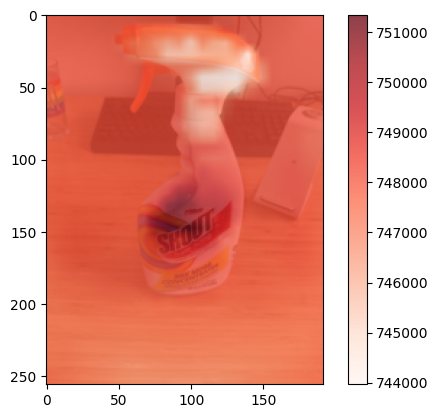

In [226]:
heatmap_resized = jax.image.resize(heatmap, rgbs_resized[ACQUISITION_T,:,:,0].shape, "linear")
plt.imshow(rgbs_resized[ACQUISITION_T])
plt.imshow(heatmap_resized, cmap="Reds", alpha=0.75)
plt.colorbar()

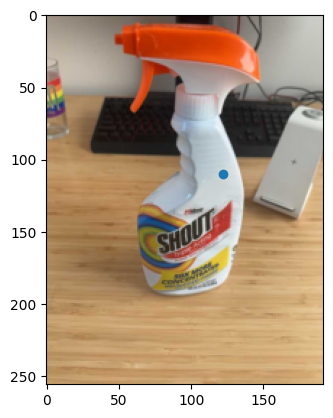

In [227]:
plt.imshow(rgbs_resized[ACQUISITION_T])
plt.scatter([x_center], [y_center])

<Figure size 640x480 with 0 Axes>

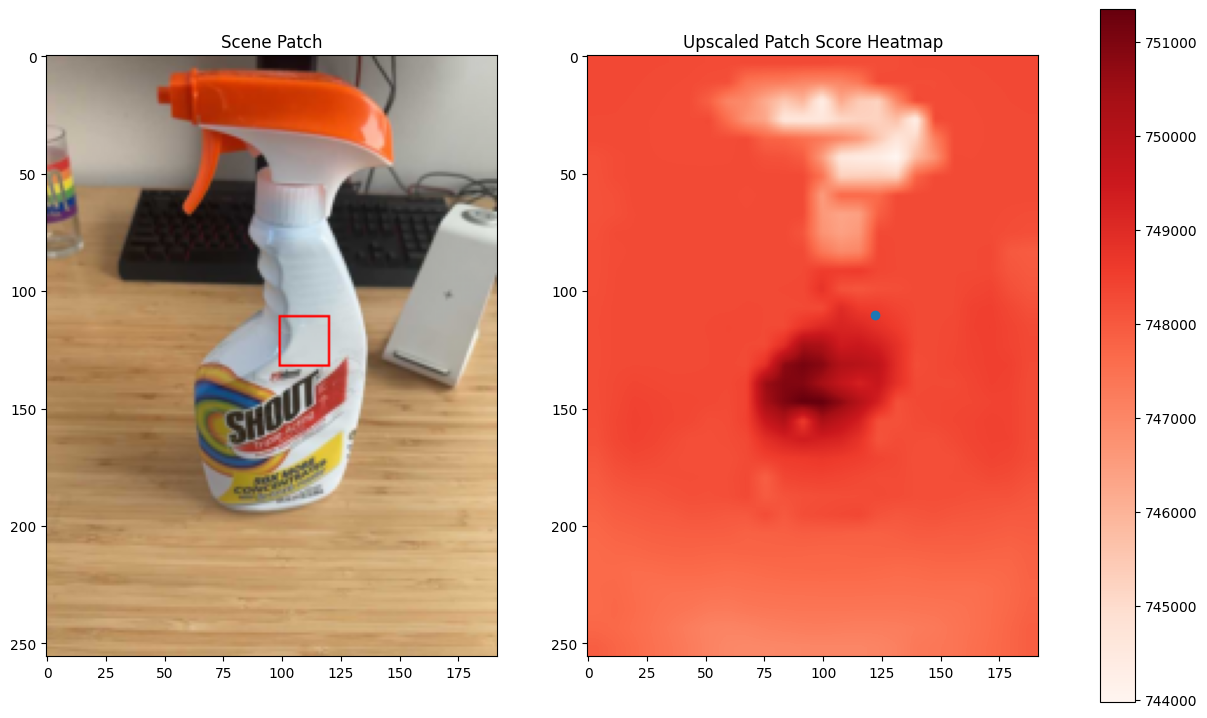

In [229]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,9))

ax = axes[0]
patch_im = np.array(rgbs_resized[ACQUISITION_T,:,:,:])
patch = np.copy(patch_im[x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:])
patch_im[x_center-del_pix-1:x_center+del_pix+1,y_center-del_pix-1:y_center+del_pix+1,:] = [1,0,0]
patch_im[x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:] = patch
ax.imshow(patch_im)
ax.title.set_text('Scene Patch')

ax=axes[1]
im = ax.imshow(heatmap_resized, cmap="Reds")
ax.title.set_text('Upscaled Patch Score Heatmap')
ax.scatter([x_center], [y_center])
fig.colorbar(im, ax=axes.ravel().tolist())


In [50]:
# vmap works same as looping
# out_temp = []
# for i in range(len(deltas)):
#     out_temp.append(enumerate_and_return_scores_v(trace, genjax.Pytree.const([f"object_pose_1"]), jax.random.PRNGKey(0), deltas[i], get_plane_pose(xyz_At, jnp.array([100, 100]))))
#     print(i)
# out_temp = jnp.array(out_temp).reshape(20,20)

In [ ]:
b3d.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), addressses, test_poses
        )

In [ ]:
trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_1"]), key, all_deltas)

In [ ]:
## pose grid should be local 2d rotations, and a single flip operation

translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.01, 0.01, 11),
        jnp.linspace(-0.01, 0.01, 11),
        jnp.linspace(-0.01, 0.01, 11),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), 11*11*11),
    Pose.identity(),
    0.00001, 1000.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])


#trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)

In [63]:
# normal of chunk patch
# the goal is to get the to align

In [41]:
maxs = jnp.max(local_points, axis=0)
mins = jnp.min(local_points, axis=0)
print(maxs, mins)

[ 0.0231984  -0.00367362  0.23962402] [ 0.0106884  -0.01496228  0.22583008]


In [45]:
xx, yy = jnp.meshgrid(jnp.linspace(mins[0], maxs[0],50), jnp.linspace(mins[1], maxs[1],50))
xx = xx.flatten()
yy = yy.flatten()

In [47]:
zz = jnp.divide((plane_normal[0] * (xx - patch_center[0]) + plane_normal[1] * (yy - patch_center[1]) - plane_normal[2] * patch_center[2]), -plane_normal[2])

In [51]:
tangent_plane = np.stack((xx, yy, zz)).T

In [38]:
rr.log("points", rr.Points3D(xyzs[ACQUISITION_T].reshape(-1,3)))

In [52]:
rr.log("tangent_plane", rr.Points3D(tangent_plane))

In [ ]:
local_points

In [ ]:
from functools import partial
@partial(jax.jit, static_argnames=['addressses'])
def enumerate_and_select_best_move(trace, addressses, key, all_deltas):
    addr = addressses.const[0]
    current_pose = trace[addr]
    for i in range(len(all_deltas)):
        test_poses = current_pose @ all_deltas[i]
        potential_scores = b3d.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), addressses, test_poses
        )
        current_pose = test_poses[potential_scores.argmax()]
    trace = b3d.update_choices(
        trace, key, addressses, current_pose
    )
    return trace, key

def update_choices(trace, key, addr_const, *values):
    addresses = addr_const.const
    return trace.update(
        key,
        genjax.choice_map({addr: c for (addr, c) in zip(addresses, values)}),
        genjax.Diff.tree_diff_unknown_change(trace.get_args())
    )[0]
update_choices_jit = jax.jit(update_choices, static_argnums=(2,))

In [9]:

# # Compute RGB and Depth outliers
# rgb_inliers, rgb_outliers = b3d.get_rgb_inlier_outlier_from_trace(trace)
# depth_inliers, depth_outliers = b3d.get_depth_inlier_outlier_from_trace(trace)
# rr.set_time_sequence("frame", T_observed_image)
# rr.log("/rgb/rgb_outliers", rr.Image(jnp.tile((rgb_outliers*1.0)[...,None], (1,1,3))))
# rr.log("/rgb/depth_outliers", rr.Image(jnp.tile((depth_outliers*1.0)[...,None], (1,1,3))))

# # Outliers are AND of the RGB and Depth outlier masks
# outler_mask = jnp.logical_and(rgb_outliers , depth_outliers)
# rr.log("outliers", rr.Image(jnp.tile((outler_mask*1.0)[...,None], (1,1,3))))


# # Get the point cloud corresponding to the outliers
# rgb, depth = trace["observed_rgb_depth"]
# point_cloud = b3d.xyz_from_depth(depth, fx,fy,cx,cy)[outler_mask]
# point_cloud_colors = rgb[outler_mask]

# # Segment the outlier cloud.
# assignment = b3d.segment_point_cloud(point_cloud)

# # Only keep the largers cluster in the outlier cloud.
# point_cloud = point_cloud.reshape(-1,3)[assignment==0]
# point_cloud_colors = point_cloud_colors.reshape(-1,3)[assignment==0]
